In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.image as mpimg
import io

'''from causallearn.search.ScoreBased.GES import ges
from causallearn.utils.GraphUtils import GraphUtils
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split'''

'from causallearn.search.ScoreBased.GES import ges\nfrom causallearn.utils.GraphUtils import GraphUtils\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.ensemble import RandomForestRegressor\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.metrics import r2_score, mean_squared_error\nfrom sklearn.model_selection import train_test_split'

In [3]:
#loading osprey data
osprey_path = '/content/drive/MyDrive/ml_climate_project_data/osprey/'

csv_files = [f for f in os.listdir(osprey_path) if f.endswith('.csv')]

osprey_df = pd.concat(
    [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
osprey_df['OBSERVATION COUNT'] = pd.to_numeric(osprey_df['OBSERVATION COUNT'], errors = 'coerce')
osprey_df = osprey_df.dropna(subset = ['OBSERVATION COUNT'])

osprey_df = osprey_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#display 5 rows
osprey_df.head()

<ipython-input-3-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-3-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-3-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-3-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  [pd.read_csv(os.path.join(osprey_path, file)) for file in sorted(csv_files)],
<ipython-input-3-79d17260af50>:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.


,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Los Angeles
1,1994-01-08,1.0,Marin
3,1994-01-13,1.0,Monterey
4,1994-01-17,1.0,Monterey
6,1994-01-15,1.0,Orange


In [4]:
#loading bald_eagle data
eagle_path = '/content/drive/MyDrive/ml_climate_project_data/bald_eagle/'

csv_files = [f for f in os.listdir(eagle_path) if f.endswith('.csv')]
bald_eagle_df = pd.concat(
    [pd.read_csv(os.path.join(eagle_path, file)) for file in sorted(csv_files)],
    ignore_index = True
)

#getting rid of missing / non-numeric values
bald_eagle_df['OBSERVATION COUNT'] = pd.to_numeric(bald_eagle_df['OBSERVATION COUNT'], errors = 'coerce')
bald_eagle_df = bald_eagle_df.dropna(subset = ['OBSERVATION COUNT'])

bald_eagle_df = bald_eagle_df[['OBSERVATION DATE', 'OBSERVATION COUNT', 'COUNTY']]

#displaying 5 rows
bald_eagle_df.head()

,OBSERVATION DATE,OBSERVATION COUNT,COUNTY
0,1994-01-09,1.0,Del Norte
1,1994-01-04,1.0,Del Norte
2,1994-01-16,1.0,Del Norte
3,1994-01-09,1.0,Del Norte
4,1994-01-20,2.0,Del Norte


In [5]:
#fish data
fish_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/fishdata.csv')

#temperature data
temp_df = pd.read_csv('/content/drive/MyDrive/ml_climate_project_data/tempdata.csv')

temp_df = temp_df[temp_df['Anomaly'] != -999]

temp_df['year'] = temp_df['Date'].astype(str).str[:4].astype(int)
temp_df['month'] = temp_df['Date'].astype(str).str[4:].astype(int)

In [6]:
#combine and join data
osprey_df["bird_type"] = "Osprey"
bald_eagle_df["bird_type"] = "Bald Eagle"
bird_df = pd.concat([osprey_df, bald_eagle_df], ignore_index = True)

bird_df['OBSERVATION DATE'] = pd.to_datetime(bird_df['OBSERVATION DATE'])
bird_df['year'] = bird_df['OBSERVATION DATE'].dt.year
bird_df['month'] = bird_df['OBSERVATION DATE'].dt.month

#combine with temperature data
bird_temp_df = bird_df.merge(temp_df[['year', 'month', 'Anomaly']], on=['year', 'month'], how='left')

#combine with fish data
combined_df = bird_temp_df.merge(fish_df, on='year', how='left')
final_df = combined_df.dropna()
final_df = final_df.rename(columns={
    "Anomaly": "temperature",
    "OBSERVATION COUNT": "bird_count",
    "Fish_Population": "fish_population",
})
print(final_df.head(10))

   OBSERVATION DATE  bird_count       COUNTY bird_type  year  month  \
0        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
2        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
3        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
4        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
12       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
13       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
14       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
15       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
19       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
36       1994-01-09         1.0  Los Angeles    Osprey  1994      1   

    temperature  Unnamed: 0    species      spawners       runsize  
0          0.89        12.0    Chinook  6.491291e+04  1.939712e+05  
2          0.89       104.0    Chinook  9.743200e+04  1.125201e+05  
3          

In [7]:
#data setup

final_df['interaction_temp_osprey'] = final_df['temperature'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_temp_bald_eagle'] = final_df['temperature'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)
final_df['interaction_fish_osprey'] = final_df['runsize'] * (final_df['bird_type'] == 'Osprey').astype(int)
final_df['interaction_fish_bald_eagle'] = final_df['runsize'] * (final_df['bird_type'] == 'Bald Eagle').astype(int)

features = ['temperature', 'runsize', 'interaction_temp_osprey', 'interaction_temp_bald_eagle',
            'interaction_fish_osprey', 'interaction_fish_bald_eagle']
target = 'bird_count'
X = final_df[features].values
y = final_df[target].values
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

print(X_tensor.shape)
print(y_tensor.shape)

print(final_df.head(10))

torch.Size([5662717, 6])
torch.Size([5662717, 1])
   OBSERVATION DATE  bird_count       COUNTY bird_type  year  month  \
0        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
2        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
3        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
4        1994-01-09         1.0  Los Angeles    Osprey  1994      1   
12       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
13       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
14       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
15       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
19       1994-01-09         1.0  Los Angeles    Osprey  1994      1   
36       1994-01-09         1.0  Los Angeles    Osprey  1994      1   

    temperature  Unnamed: 0    species      spawners       runsize  \
0          0.89        12.0    Chinook  6.491291e+04  1.939712e+05   
2          0.89       104.0 

In [8]:
#merge data
final_df['OBSERVATION DATE'] = pd.to_datetime(final_df['OBSERVATION DATE'])

monthly_summary = final_df.groupby(['year', 'month', 'bird_type']).agg({
    'bird_count': 'sum',
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

bird_pivot = monthly_summary.pivot_table(index = ['year', 'month'],
                                         columns = 'bird_type',
                                         values = 'bird_count',
                                         fill_value = 0).reset_index()

bird_pivot.columns.name = None
bird_pivot = bird_pivot.rename(columns = {
    'Osprey': 'osprey_count',
    'Bald Eagle': 'bald_eagle_count'
})

temp_fish = monthly_summary.groupby(['year', 'month']).agg({
    'temperature': 'mean',
    'runsize': 'mean',
    'spawners': 'mean'
}).reset_index()

merged_df = pd.merge(bird_pivot, temp_fish, on = ['year', 'month'], how = 'left')
merged_df['interaction'] = merged_df['temperature'] * merged_df['bald_eagle_count']

print(merged_df.head(10))

   year  month  bald_eagle_count  osprey_count  temperature       runsize  \
0  1994      1             165.0         143.0         0.89  2.058768e+06   
1  1994      2             242.0          99.0         0.67  2.058768e+06   
2  1994      3             209.0         286.0         0.75  2.058768e+06   
3  1994      4              44.0         209.0         0.63  2.058768e+06   
4  1994      5              66.0         154.0         0.52  2.058768e+06   
5  1994      6              11.0         132.0         0.50  2.058768e+06   
6  1994      7              11.0         132.0         0.51  2.058768e+06   
7  1994      8              22.0         220.0         0.26  2.058768e+06   
8  1994      9              33.0         396.0         0.46  2.058768e+06   
9  1994     10              33.0         286.0         0.51  2.058768e+06   

        spawners  interaction  
0  470649.146682       146.85  
1  470649.146682       162.14  
2  470649.146682       156.75  
3  470649.146682        

Text(0.5, 1.0, 'Bird Population Over Time')

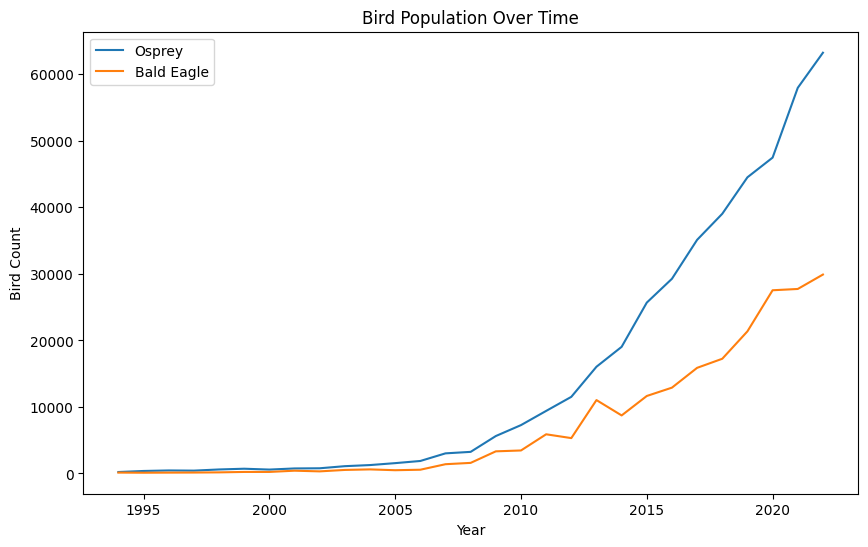

In [9]:
plt.figure(figsize = (10, 6))
before_23 = merged_df[merged_df['year'] < 2023]
sns.lineplot(data = before_23, x = 'year', y = 'osprey_count', label = 'Osprey', errorbar=None)
sns.lineplot(data = before_23, x = 'year', y = 'bald_eagle_count', label = 'Bald Eagle', errorbar=None)
plt.ylabel('Bird Count')
plt.xlabel('Year')
plt.title('Bird Population Over Time')
# sns.lineplot(data = merged_df, x = 'year', y = 'spawners', label = 'Spawners')

In [10]:
temp_by_year_df = temp_df.groupby('year').mean('Anomaly')
#print(temp_df.head(10))

['Chinook' 'Chum' 'Coho' 'Pink' 'Sockeye' 'Steelhead']


<Axes: xlabel='year', ylabel='spawners'>

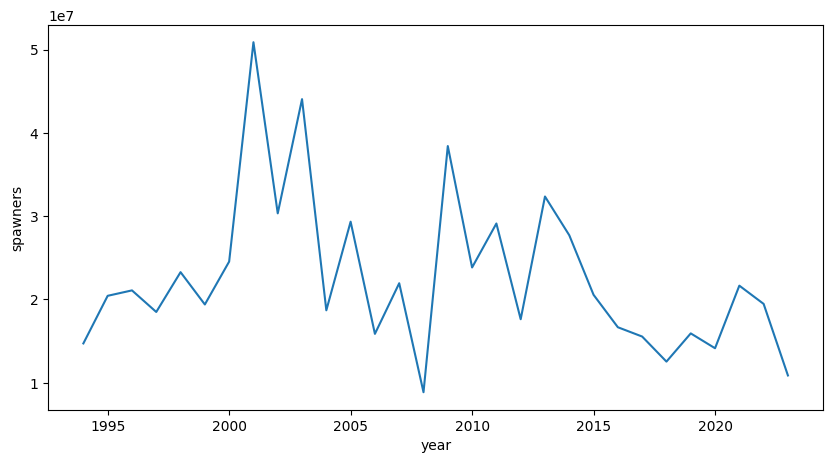

In [11]:
fish_df
print(np.unique(fish_df['species'].values))
fish_df2 = fish_df.groupby('year').sum('spawners')

chum = fish_df[fish_df['species'] == 'Chum'].groupby('year').sum('spawners')
coho = fish_df[fish_df['species'] == 'Coho']
sockeye = fish_df[fish_df['species'] == 'Sockeye']

plt.figure(figsize = (10, 5))
sns.lineplot(data = fish_df2, x = 'year', y = 'spawners')
#sns.lineplot(data = temp_by_year_df, x='year', y='Anomaly')
#sns.lineplot(data = coho, x = 'year', y = 'spawners')
#sns.lineplot(data = sockeye, x = 'year', y = 'spawners')
#plt.ylim(chinook['spawners'].min() - 10, chinook['spawners'].max() + 10)

<ipython-input-12-679c983a7c57>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left')


Text(0.5, 1.0, 'Temperature vs Spawners Overtime')

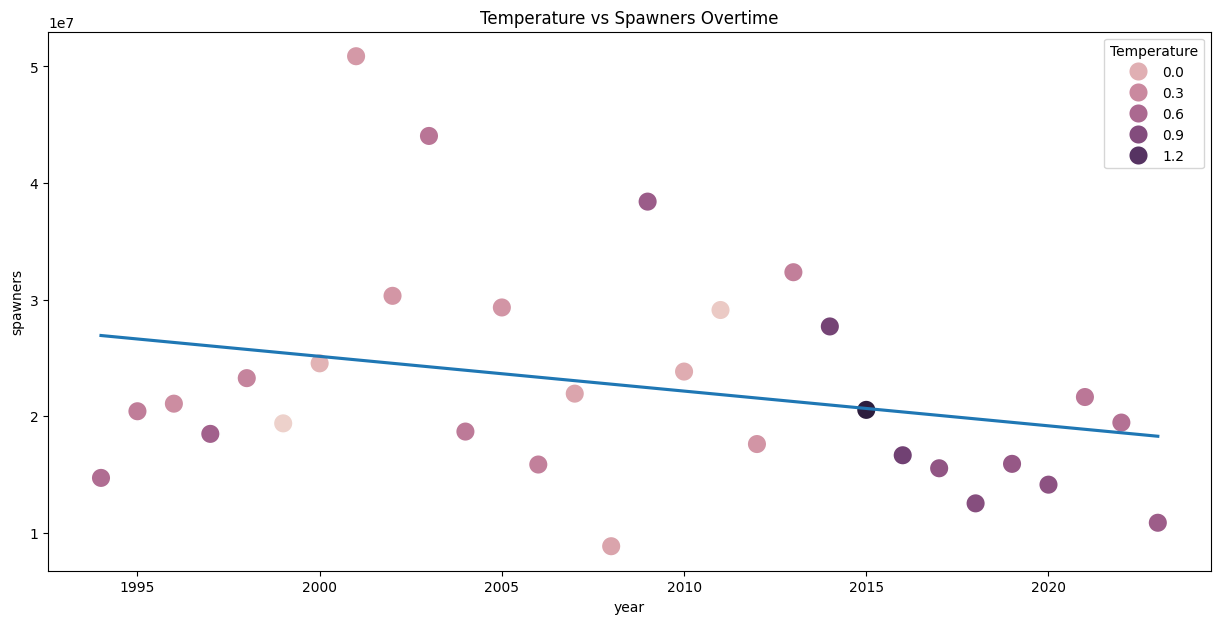

In [12]:
#plt.xlabel = plt.xlabel
plt.figure(figsize = (15, 7))
#sns.lineplot(data = fish_df2, x = 'year', y = 'spawners')
third_plot = pd.merge(temp_by_year_df, fish_df2, on = 'year', how = 'left')
third_plot = third_plot.rename(columns={'Anomaly': 'Temperature'})
plt.xlabel('Year')
plt.ylabel('Spawners')
plt.legend(loc='upper left')
sns.scatterplot(
    data=third_plot,
    x='year',
    y='spawners',
    size='Temperature',
    hue='Temperature',
    #legend=False,
    #sizes=(50, 250),
    sizes = (200, 200)
)
#sns.lineplot(data = third_plot, x = 'year', y = 'Anomaly') #, color = 'red')
third_plot = third_plot.reset_index()
sns.regplot(data=third_plot, x = 'year', y = 'spawners', scatter=False, ci=None) #, scatter=False, color='red')
#plt.show()
plt.title('Temperature vs Spawners Overtime')

In [13]:
data_1994 = merged_df[merged_df['year'] == 1994]
data_2010 = merged_df[merged_df['year'] == 2010]
data_2023 = merged_df[merged_df['year'] == 2023]
'''plt.figure(figsize = (10, 6))
sns.lineplot(data = data_1994, x = 'month', y = 'temperature', label = '1994')
sns.lineplot(data = data_2010, x = 'month', y = 'temperature', label = '2010')
sns.lineplot(data = data_2023, x = 'month', y = 'temperature', label = '2023')'''

"plt.figure(figsize = (10, 6))\nsns.lineplot(data = data_1994, x = 'month', y = 'temperature', label = '1994')\nsns.lineplot(data = data_2010, x = 'month', y = 'temperature', label = '2010')\nsns.lineplot(data = data_2023, x = 'month', y = 'temperature', label = '2023')"

In [14]:
#chum.groupby('year').sum('spawners')